# Homework 0 Part 2

This is an individual assignment.

---

Write your own code. You may repurpose any functions built during lecture. You may use ```scikit-learn``` functions.

---

## Custom Transformers

```scikit-learn``` offers many useful transformers, but you will likely need to write your own transformers for tasks such as custom cleanup operations or combining specific attributes.

To have your transformer working seamlessly with ```scikit-learn```, all you need to do is create a class and implement three methods: ```fit()``` (returning self), ```transform()```, and ```fit_transform()```.

You can get the last one for free by simply adding ```TransformerMixin``` as your base class. If you add ```BaseEstimator``` as a base class (and avoid ```*args``` and ```**kargs``` you will also get two extra methods (```get_params()``` and ```set_params()```) that will be useful for automatic hyperparameter tuning.

For example, for the dataset we discussed in lecture 3 (California housing prices), we can build a transformer to add the custom attributes as follows:

````python
from sklearn.base import BaseEstimator, TransformerMixin 

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__ (self, add_bedrooms_per_room=True): # no *args or **kargs 
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None): 
        return self # nothing else to do 
    def transform(self, X): 
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
        population_per_household = X[:, population_ix] / X[:, households_ix] 
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix] 
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
````

This transformer can later be added to a ```scikit-learn``` pipeline like this:

````python
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                         ('attribs_adder', CombinedAttributesAdder()), 
                         ('std_scaler', StandardScaler())]) 

housing_num_tr = num_pipeline.fit_transform(housing_num)
````

---

# Exercise 1 (5 points)

In this question, you will practice how to use HiPerGator and Git to maintain your code.

1. (1.5 points) Open Open On-Demand [ood.rc.ufl.edu](ood.rc.ufl.edu) and create an interactive jupyter session with the following specifications: 2 CPU, 2 GPU (type = 'a100') and 4 GB of RAM. **Attach a screenshot of your jupyter notebook card, your gatorlink should be visible.**

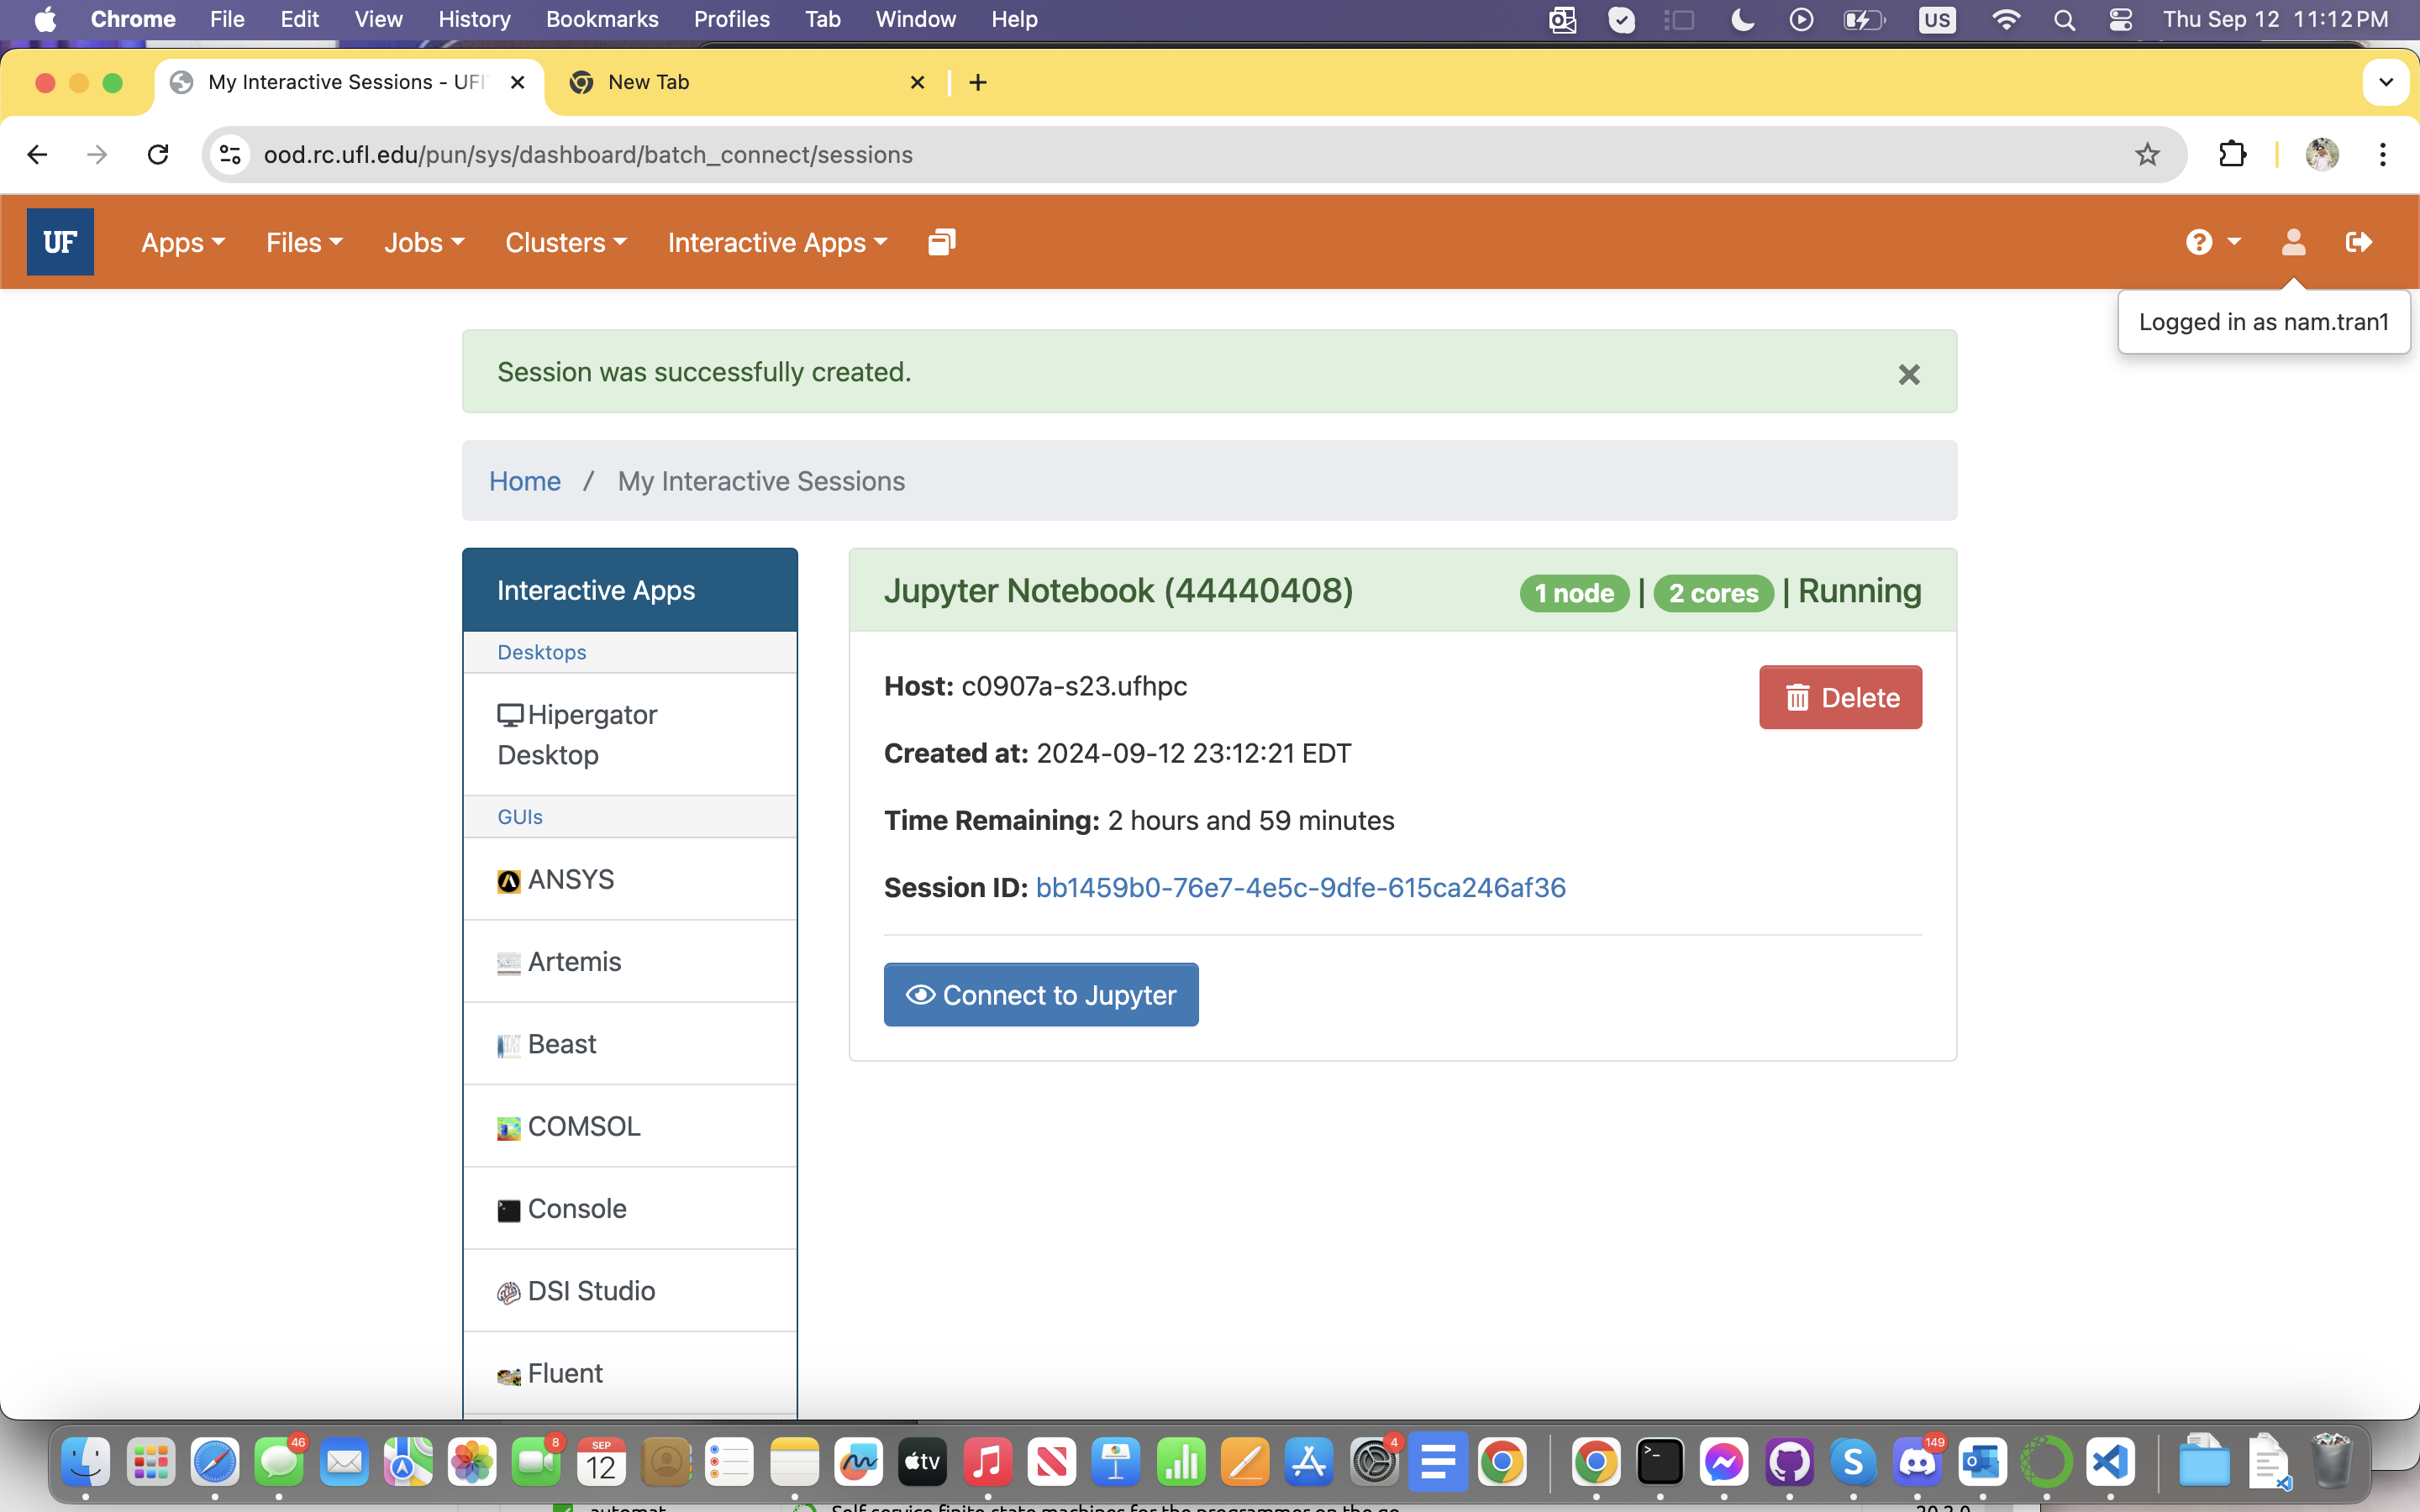

In [31]:
from IPython.display import Image
Image('figures/namtran_ood.png', width=900)

2. (1.5 points) Create a symbolic link to map the class blue directory in your homepage. **Attach a screenshot to show that this link has been created.**

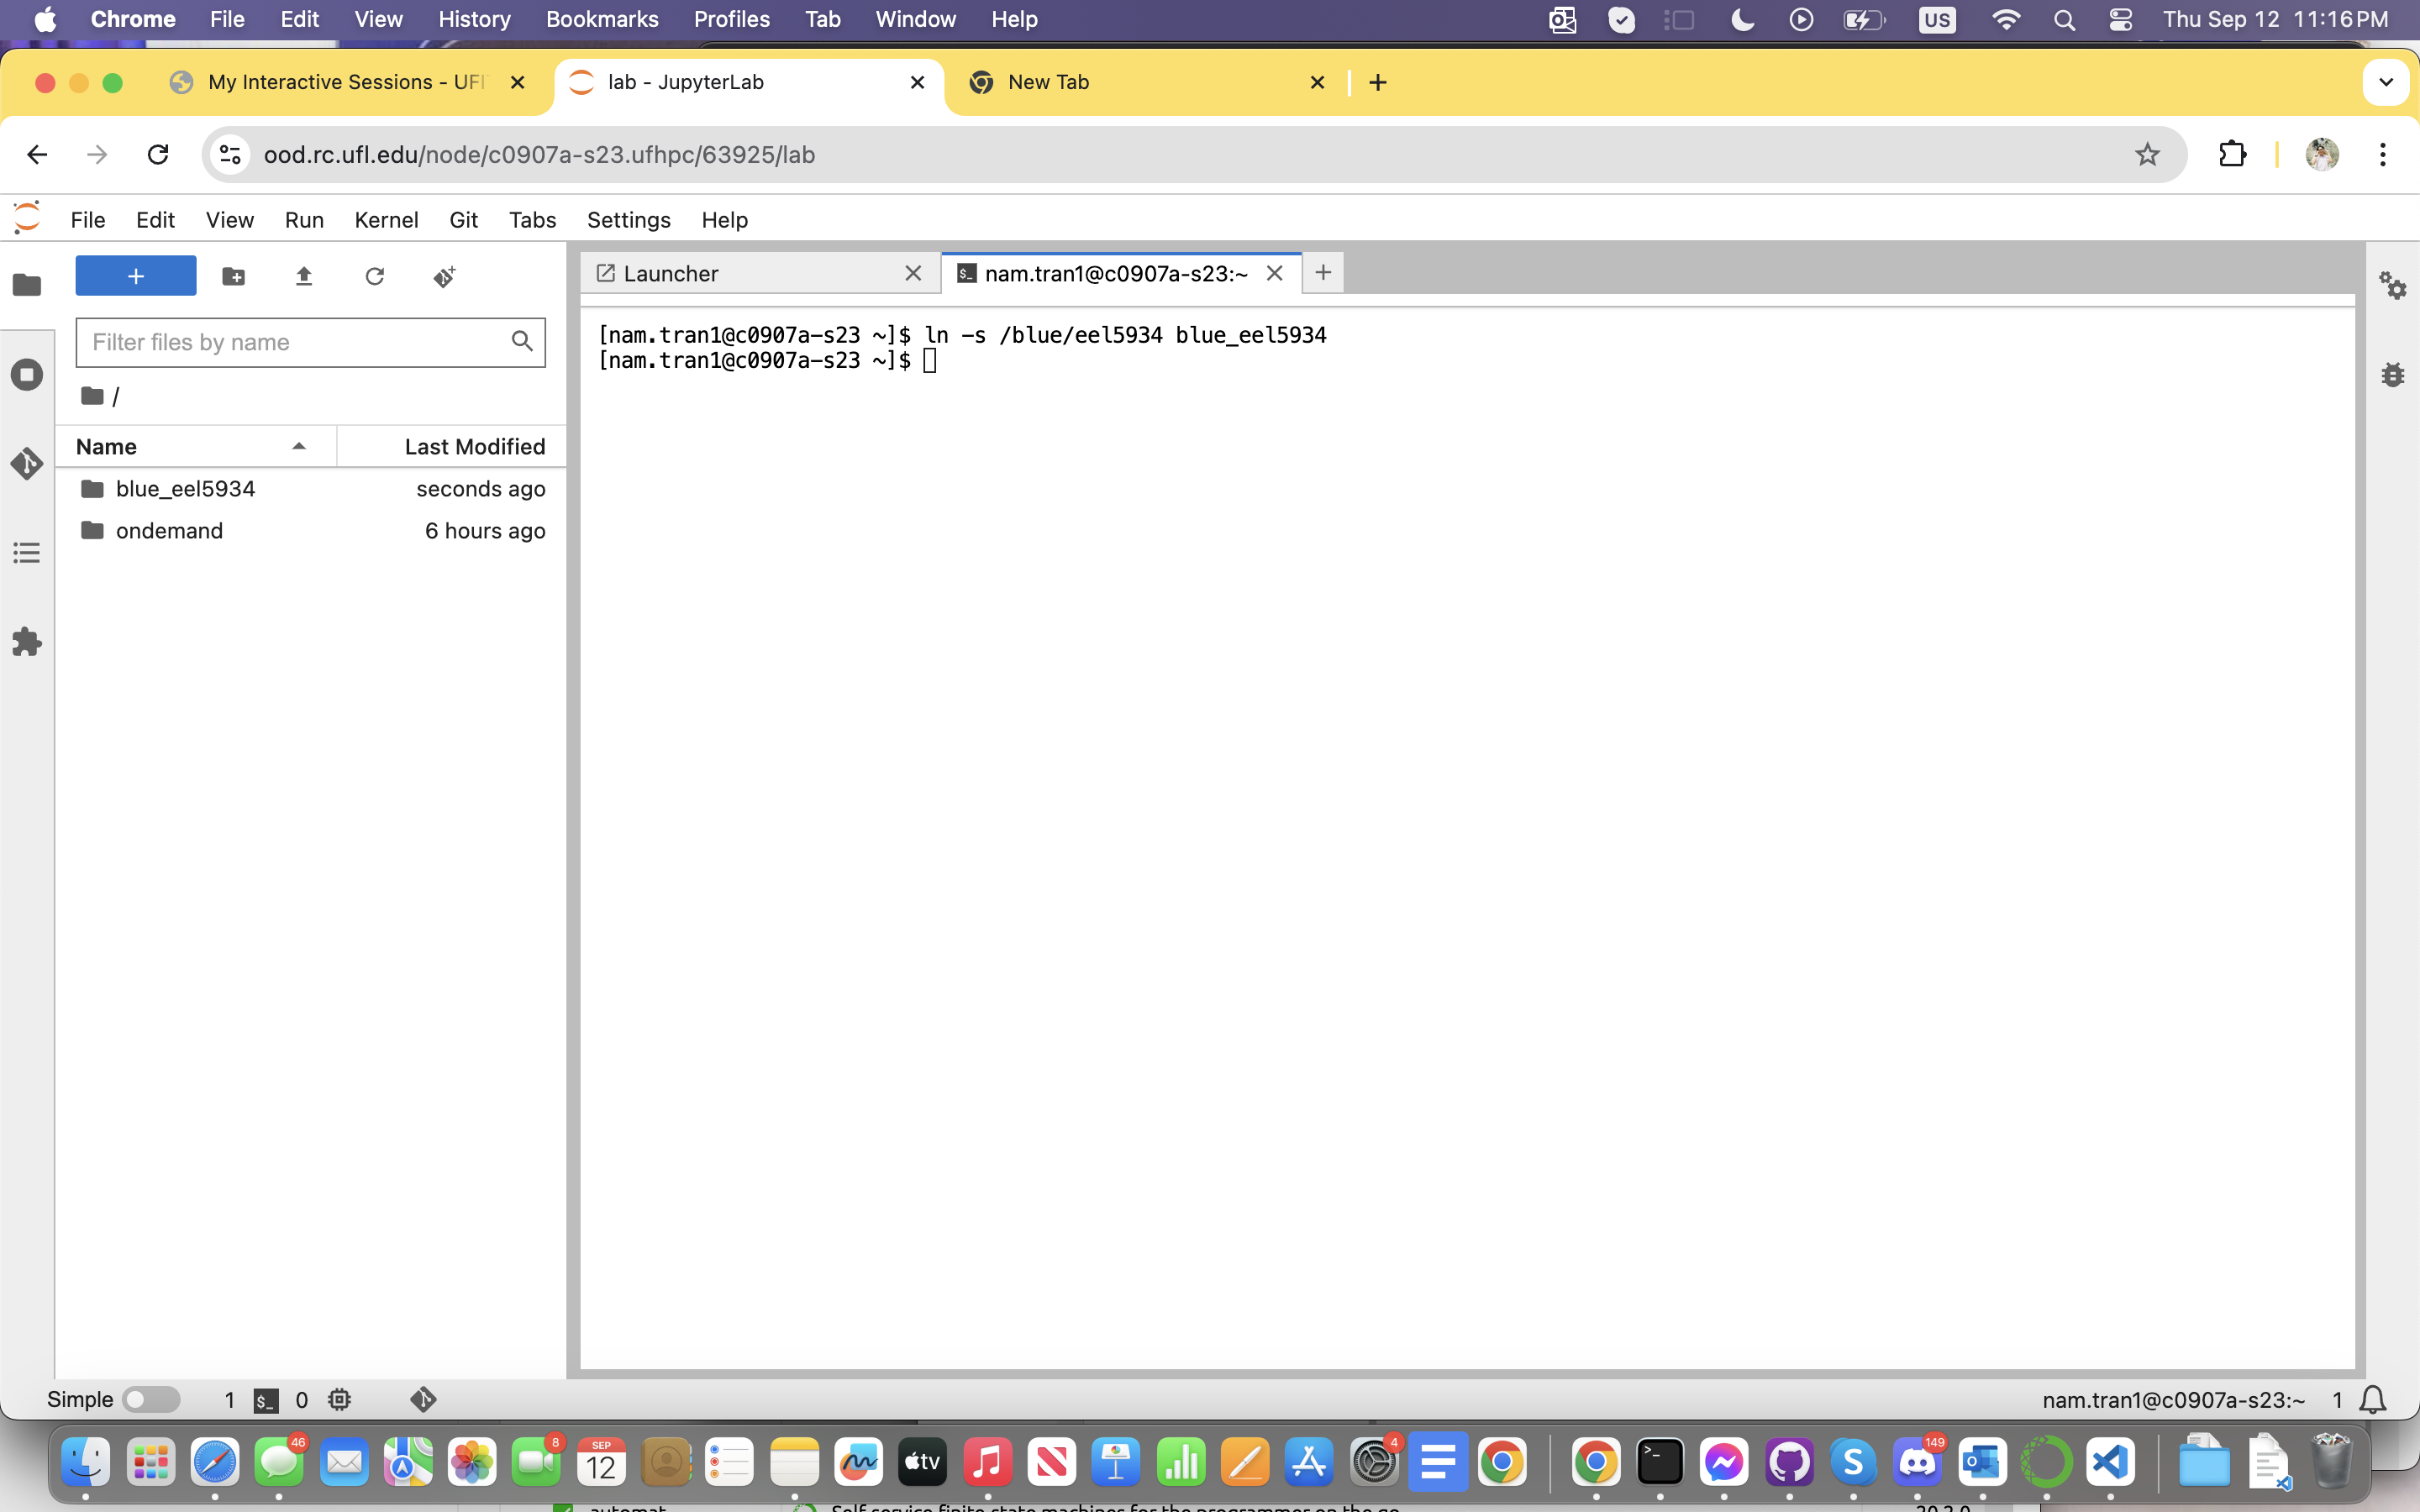

In [32]:
Image('figures/namtran_link.png', width=900)

3. (2 points) Navigate to your folder within the symbolic link you just created. Clone the HW0 repository inside that folder - see the picture below. If you clone outside your personal and private folder (mine is blue_aml_f23/catiaspsilva), you will lose points. **Attach a screenshot.**

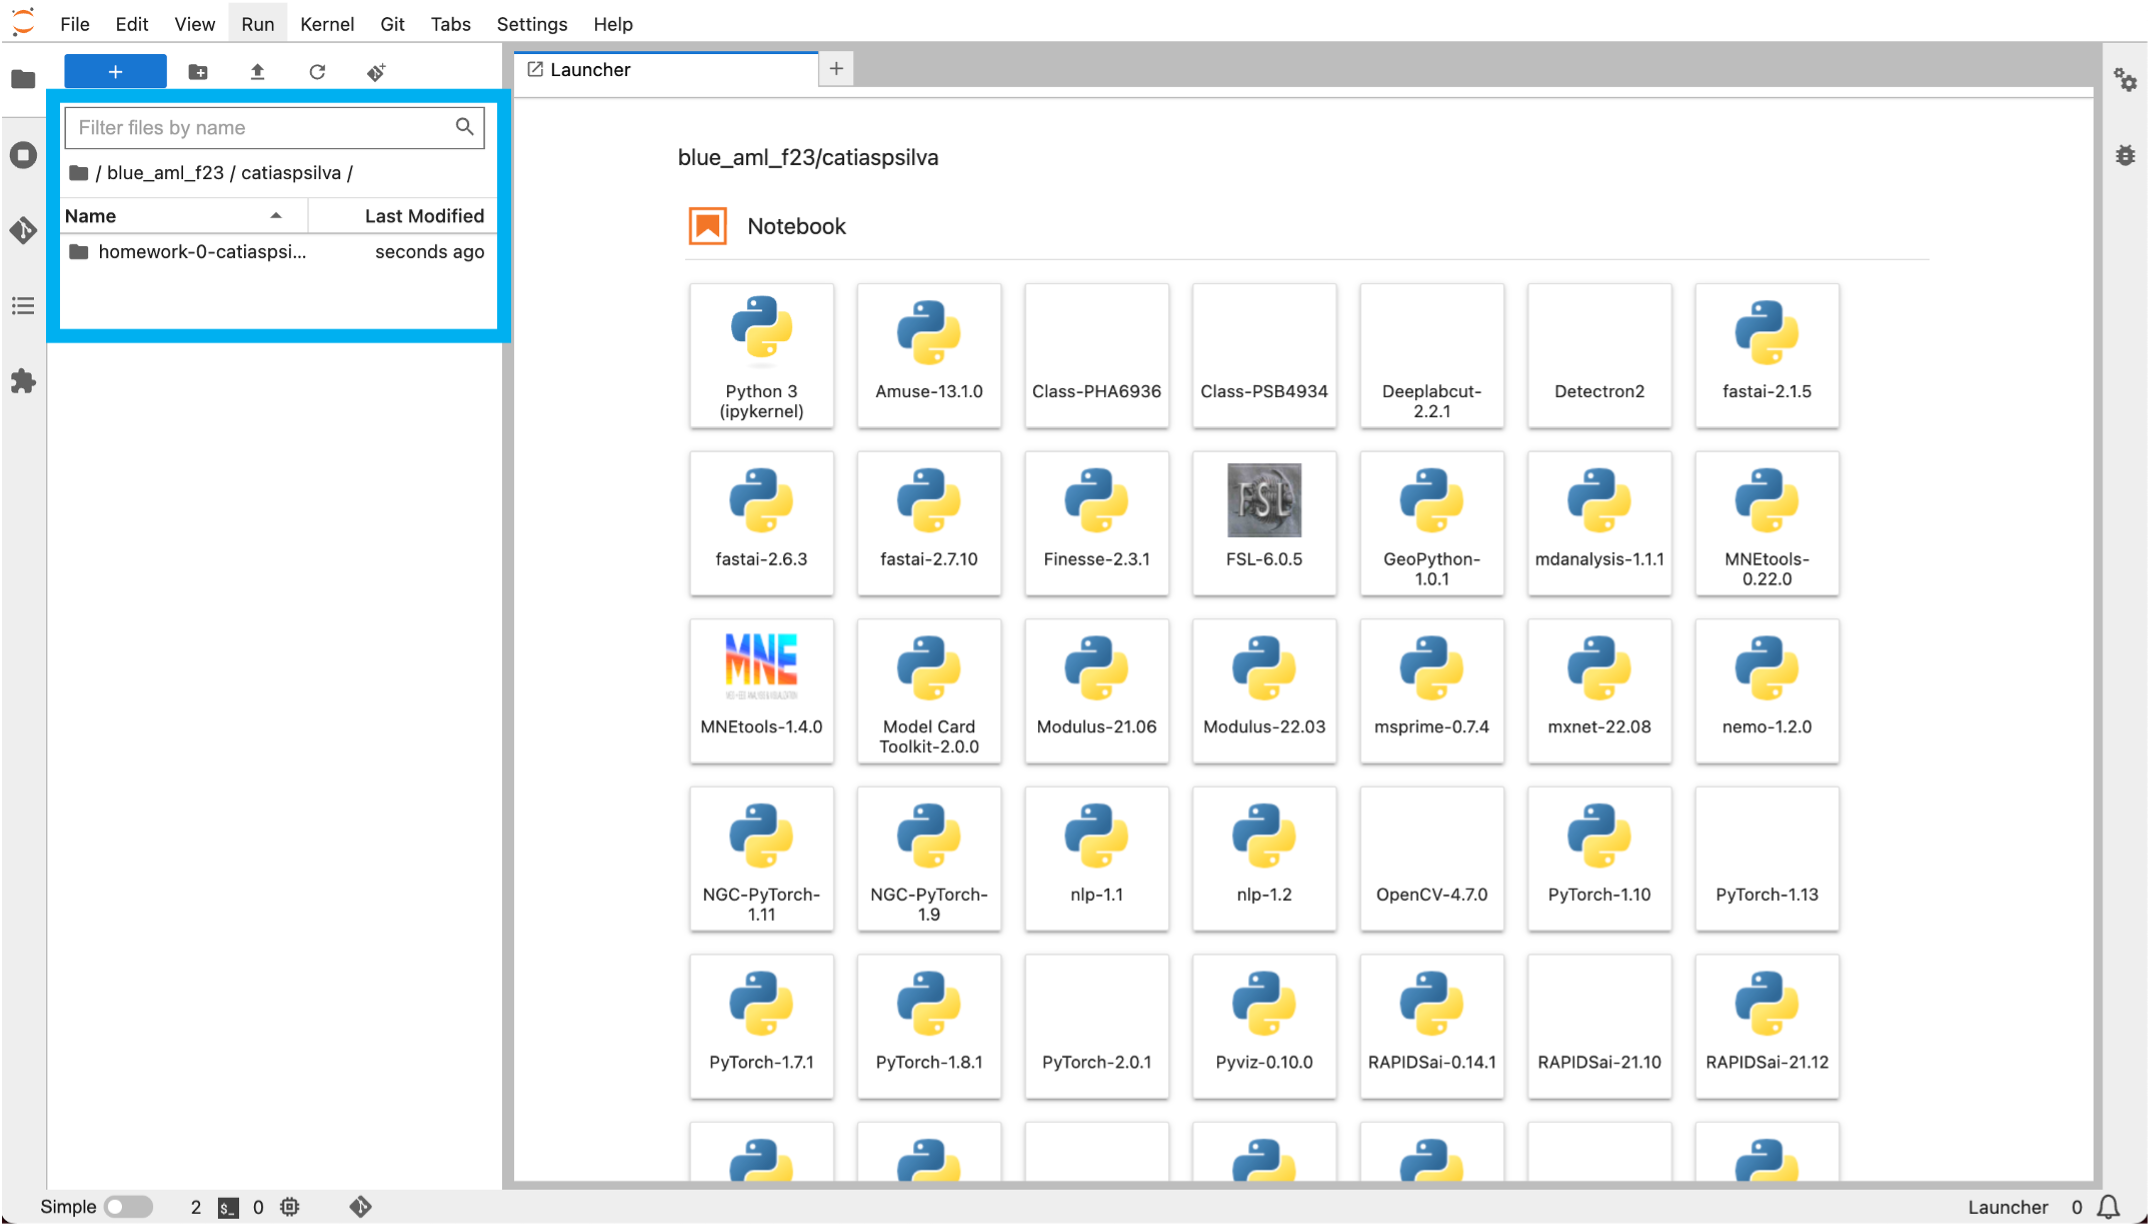

In [33]:
Image('figures/cloning_repo.png', width=900)

---

# Exercise 2 (40 points)

In this question, you will be working with the [marathon time predictions dataset](https://www.kaggle.com/datasets/girardi69/marathon-time-predictions).

### Attributes

* **id**: simple counter

* **Marathon**: the Marathon name where the data were extracted.

* **Name**: The athlete's name.

* **Category**: the sex and age group of a runner.
    * MAM Male Athletes under 40 years
    * WAM Women under 40 Years
    * M40 Male Athletes between 40 and 45 years

* **km4week**: This is the total number of kilometers run in the last 4 weeks before the marathon, marathon included. If, for example, the km4week is 100, the athlete has run 400 km in the four weeks before the marathon.

* **sp4week**: This is the average speed of the athlete in the last 4 training weeks. The average counts all the kilometers done, included the slow kilometers done before and after the training. A typical running session can be of 2km of slow running, then 12-14km of fast running, and finally other 2km of slow running. The average of the speed is this number, and with time this is one of the numbers that has to be refined.

* **cross training**: If the runner is also a cyclist, or a triathlete.

* **Wall21**: To acknowledge a good performance, as a marathoner, the first half marathon should be run with the same split of the second half. If, for example, I run the first half marathon in 1h30m, I must finish the marathon in 3h (for doing a good job). If I finish in 3h20m, I started too fast and I hit "the wall". My training history is, therefore, less valid, since I was not estimating my result.

* **Marathon time**: This is target value.

* **Category**: Categorical encoding of the target value. It groups in:
    * A results under 3h
    * B results between 3h and 3h20m
    * C results between 3h20m and 3h40m
    * D results between 3h40 and 4h

In [34]:
# Import libraries and magics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**Answer the following questions:**

1. (1 point) **Load the data with ```pandas```.**

In [35]:
# Load the CSV file
marathondata = pd.read_csv('MarathonData.csv')
marathondata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             87 non-null     int64  
 1   Marathon       87 non-null     object 
 2   Name           87 non-null     object 
 3   Category       81 non-null     object 
 4   km4week        87 non-null     float64
 5   sp4week        87 non-null     float64
 6   CrossTraining  13 non-null     object 
 7   Wall21         87 non-null     object 
 8   MarathonTime   87 non-null     float64
 9   CATEGORY       87 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 6.9+ KB


2. (3 points) **Are there missing samples? Determine which approach you are going to use to handle missing data. All justifications and reasoning must be included in a markdown cell.**

In [36]:
#Check the missing samples
print(marathondata.isnull().sum())

id                0
Marathon          0
Name              0
Category          6
km4week           0
sp4week           0
CrossTraining    74
Wall21            0
MarathonTime      0
CATEGORY          0
dtype: int64


In [37]:
imputer = SimpleImputer(strategy="median") 
numerical_columns = marathondata.select_dtypes(include=[np.number]).columns 
imputer.fit(marathondata[numerical_columns])

# Transform the data
marathondata[numerical_columns] = imputer.transform(marathondata[numerical_columns]) 
marathondata[numerical_columns]

,id,km4week,sp4week,MarathonTime
0,1.0,132.8,14.434783,2.37
1,2.0,68.6,13.674419,2.59
2,3.0,82.7,13.520436,2.66
3,4.0,137.5,12.258544,2.68
4,5.0,84.6,13.945055,2.74
...,...,...,...,...
82,83.0,50.0,10.830325,3.93
83,84.0,33.6,10.130653,3.93
84,85.0,55.4,11.043189,3.94
85,86.0,33.2,11.066667,3.95


3. (3 points) **Print the Pearson's correlation matrix and visualize the data. Which attribute has the largest predictive value to predict the marathon time?**

In [38]:
correlation_matrix = marathondata.corr(method = 'pearson', numeric_only = True)
correlation_matrix

,id,km4week,sp4week,MarathonTime
id,1.000000,-0.599675,0.162553,0.991548
km4week,-0.599675,1.000000,-0.107429,-0.606782
sp4week,0.162553,-0.107429,1.000000,0.172294
MarathonTime,0.991548,-0.606782,0.172294,1.000000


The attribute with the largest predictive value for marathon time is km4week, as it has the highest absolute correlation coefficient with MarathonTime (-0.606782). The negative sign indicates that as the kilometers run per week increases, the marathon time tends to decrease.

In [39]:
correlation_with_time = correlation_matrix['MarathonTime'].sort_values(ascending=False)
correlation_with_time

MarathonTime    1.000000
id              0.991548
sp4week         0.172294
km4week        -0.606782
Name: MarathonTime, dtype: float64

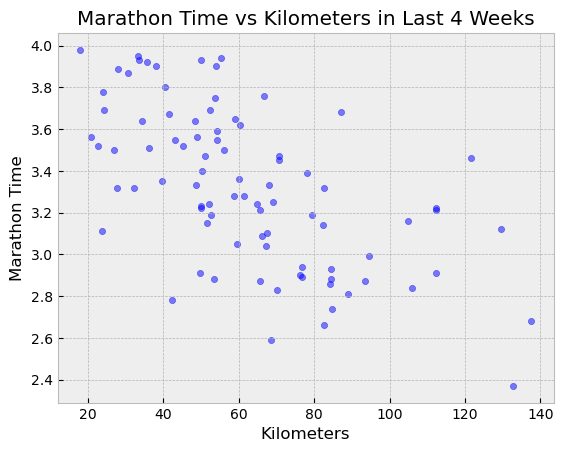

In [40]:
marathondata.plot(kind='scatter', x='km4week', y='MarathonTime', alpha= 0.5) 
plt.title('Marathon Time vs Kilometers in Last 4 Weeks') 
plt.xlabel('Kilometers')
plt.ylabel('Marathon Time')
plt.show()

4. (9 points) **Create a new attribute that computes the ratio between the ```km4week``` and ```sp4week```. Build a custom transformer to automate this feature extraction (see example at the top of this notebook).**

In [41]:
#Define custom transformer for km4week/sp4week ratio
class RatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        km4week = X[:, numerical_columns.index('km4week')]
        sp4week = X[:, numerical_columns.index('sp4week')]
        km_speed_ratio = km4week / sp4week
        return np.c_[X, km_speed_ratio]

5. (3 points) **Partition the data into training and test sets. If you use stratified partition, justify your answer.**

In [42]:
# Use stratified partition based on the 'Category' column
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(marathondata, marathondata['CATEGORY']):
    train_set = marathondata.loc[train_index]
    test_set = marathondata.loc[test_index]

# Separate features and target for stratified train and test sets
X_train = train_set.drop('MarathonTime', axis=1)
y_train = train_set['MarathonTime']

X_test = test_set.drop('MarathonTime', axis=1)
y_test = test_set['MarathonTime']

In this case, as the dataset provided is relatively small and all categories are well-balanced, I adopted stratified partitioning so that each category would retain its proportion in both training and testing sets. This may result in category imbalance thus leading to an inaccurate model performance. The stratification will enable generating representative and balanced data useful for assessing the efficacy of the models, as well as ensuring that their predictions are precise.

6. (3 points) **Build a transformation pipeline with ```scikit-learn``` to encode any categorical attributes.**

In [43]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

7. (9 points) **Build a transformation pipeline with ```scikit-learn``` to encode the numerical attributes. This pipeline should include your custom transformer built in step 4.**

In [44]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('ratio_transform', RatioTransformer()),
    ('scaler', StandardScaler())])

8. (9 points) **Build a transformation pipeline that combines both categorical and numerical attributes.**

In [45]:
# Combine categorical and numerical pipelines
numerical_columns = ['km4week', 'sp4week']
categorical_columns = ['Marathon', 'Category']

preprocessor = ColumnTransformer([ ('num', numerical_pipeline, numerical_columns), 
                                  ('cat', categorical_pipeline, categorical_columns)])
full_pipeline = Pipeline([('preprocessor', preprocessor)])

# Fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

---

# On-Time (5 points)

Submit your assignment before the deadline.

___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___